In [1]:
pip install torchmetrics

  Using cached torchmetrics-0.7.2-py3-none-any.whl (397 kB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-93a894rp
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-93a894rp
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264351 sha256=4c8e134979fef4d049c725f14ab89e8a3a62d6fcbcbda8d481be84aa0e03cc3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yrycg13/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 105290, done.
remote: Counting objects: 100% (40421/40421), done.
remote: Compressing objects: 100% (3216/3216), done.
remote: Total 105290 (delta 37431), reused 39703 (delta 36997), pack-reused 64869
Receiving objects: 100% (105290/105290), 206.58 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (90506/90506), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils

from torchmetrics.detection.map import MeanAveragePrecision

If you are using Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!tar -xf "/content/gdrive/MyDrive/IFT-Projets/eccv_18_all_images_sm.tar" -C "/content/gdrive/MyDrive/IFT-Projets/output"    #[run this cell to extract tar files] # images

tar: /content/gdrive/MyDrive/IFT-Projets/eccv_18_all_images_sm.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!tar -xvf "/content/gdrive/MyDrive/IFT-Projets/eccv_18_annotations.tar" -C "/content/gdrive/MyDrive/IFT-Projets/output"   #[run this cell to extract tar files] # labels

eccv_18_annotation_files/
eccv_18_annotation_files/cis_test_annotations.json
eccv_18_annotation_files/trans_test_annotations.json
eccv_18_annotation_files/trans_val_annotations.json
eccv_18_annotation_files/train_annotations.json
eccv_18_annotation_files/cis_val_annotations.json


Example of data in annotation files

In [ ]:
output_path='/content/gdrive/MyDrive/IFT-Projets/output'
img_folder= '/content/gdrive/MyDrive/IFT-Projets/output/eccv_18_all_images_sm'

cis_test_ann_path= output_path +'/eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path= output_path + '/eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = output_path + '/eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path= output_path + '/eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = output_path + '/eccv_18_annotation_files/trans_val_annotations.json'


Number of images per split

In [ ]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann= json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [ ]:
print(len(cis_test_ann['images']))
print(len(cis_val_ann['images']))
print(len(train_ann['images']))
print(len(trans_test_ann['images']))
print(len(trans_val_ann['images']))

15827
3484
13553
23275
1725


In [ ]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [ ]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'version': 'Caltech Camera Traps - ECCV18',
 'year': 2018}

In [ ]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [ ]:
trans_val_ann['annotations'][0]

{'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'category_id': 6,
 'id': '19220',
 'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b'}

## Horizontal flip debugging

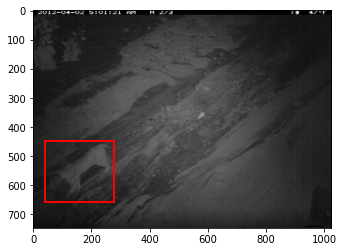

In [ ]:
i=500

boxes= [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('/content/gdrive/MyDrive/IFT-Projets/output/eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x=image.shape[2]/trans_val_ann['images'][i]['width'] 
scale_y=image.shape[1]/trans_val_ann['images'][i]['height']

boxes=torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
  boxes[i][0]=torch.round(boxes[i][0]*scale_x)
  boxes[i][1]=torch.round(boxes[i][1]*scale_y)
  boxes[i][2]=torch.round(boxes[i][2]*scale_x)
  boxes[i][3]=torch.round(boxes[i][3]*scale_y)

  boxes[i][2]=boxes[i][0]+boxes[i][2]
  boxes[i][3]=boxes[i][1]+boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [ ]:
image = Image.open(img_path).convert("RGB")
#image=conv(image)

In [ ]:
image.shape

torch.Size([3, 747, 1024])

In [ ]:
conv=torchvision.transforms.ToTensor()

In [ ]:
width, height = image.size[0]

In [ ]:
image.size[0]

1024

In [ ]:
width

1024

In [ ]:
image_new=conv(image)

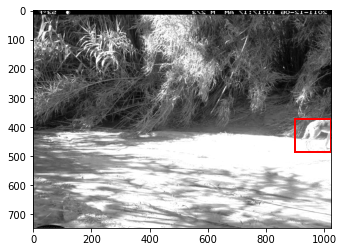

In [ ]:
trans= data_transform['train']
img2,target2= trans(image,target)

fig, ax = plt.subplots()
ax.imshow(img2[0].squeeze(),cmap="gray")

rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), target2['boxes'][0][2]-target2['boxes'][0][0], target2['boxes'][0][3]-target2['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Utils

In [ ]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {
    'train': T.RandomHorizontalFlip(0.5)}

In [ ]:
def get_img_with_bbox(file_path):
  
  # returns a list with the idx of images with at least one bounding box (img_wbbox) and a list with the number of bbox for each valid image (num_bbox)
  file = json.load(open(file_path))
  img_wbbox=[]
  num_bbox=[]

  for i in range(len(file['images'])):
    bboxes= [file['annotations'][j]['bbox'] for j in range(len(file['annotations'])) if file['annotations'][j]['image_id']==file['images'][i]['id'] and 'bbox' in file['annotations'][j].keys()]

    if len(bboxes)!=0:
      img_wbbox.append(i)

      num_bbox.append(len(bboxes))

  return img_wbbox, num_bbox

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform= None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img= valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx=self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv=torchvision.transforms.ToTensor()
        #if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image=conv(image)

        boxes= [self.label_file['annotations'][j]['bbox'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        label= [self.label_file['annotations'][j]['category_id'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x=image.shape[2]/self.label_file['images'][idx]['width'] 
        scale_y=image.shape[1]/self.label_file['images'][idx]['height']

        boxes=torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
          boxes[i][0]=torch.round(boxes[i][0]*scale_x)
          boxes[i][1]=torch.round(boxes[i][1]*scale_y)
          boxes[i][2]=torch.round(boxes[i][2]*scale_x)
          boxes[i][3]=torch.round(boxes[i][3]*scale_y)

          boxes[i][2]=boxes[i][0]+boxes[i][2] # to transform to pytorch bbox format
          boxes[i][3]=boxes[i][1]+boxes[i][3]

          #boxes[i][0]*=scale_x
          #boxes[i][1]*=scale_y
          #boxes[i][2]*=scale_x
          #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
          # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target


Example of use

In [ ]:
train_valid_img,_= get_img_with_bbox(train_ann_path)   # takes about 1min to run on train data
cis_val_valid_img,_= get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data


In [ ]:
training_data= CustomImageDataset(train_ann_path,img_folder, train_valid_img)
valid_data= CustomImageDataset(cis_val_ann_path,img_folder, val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True,collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

Target (Bbox) batch shape: torch.Size([1, 4])
Target (category) batch shape: torch.Size([1])
Label: animal


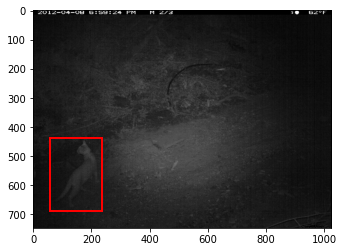

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
  label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

## Pre-trained model

In [ ]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [ ]:
def get_model_from_pretrained(num_classes):

  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  for param in model.parameters(): # to freeze all existing weights
    param.requires_grad = False

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)
valid_dataloader= DataLoader(valid_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
trans_val_valid_img,_= get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data= CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader= DataLoader(trans_valid_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
cis_val_valid_img,_= get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data= CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader= DataLoader(cis_valid_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
# !!TO DO : replace this 'return coco_evaluator' by this 'return metric_logger' on line 
# #109 of engine.py in evaluate function and CTRL+S

In [ ]:
# way around weird behav
#del evaluate
#from engine_modif import train_one_epoch, evaluate

In [ ]:
del evaluate

In [ ]:
from engine_modif_new5 import evaluate

In [ ]:
# TRAIN

all_train_logs=[]
all_trans_valid_logs=[]
all_cis_valid_logs=[]

num_epochs = 3

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_logs=train_one_epoch(model, optimizer, trans_valid_dataloader, device, epoch, print_freq=100)
  all_train_logs.append(train_logs)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  trans_valid_logs=evaluate(model, trans_valid_dataloader, device=device)
  cis_valid_logs=evaluate(model, cis_valid_dataloader, device=device)
  
  all_trans_valid_logs.append(trans_valid_logs)
  all_cis_valid_logs.append(cis_valid_logs)

Epoch: [0]  [   0/1533]  eta: 0:02:49  lr: 0.000001  loss: 0.0777 (0.0777)  loss_classifier: 0.0231 (0.0231)  loss_box_reg: 0.0531 (0.0531)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.1105  data: 0.0321  max mem: 651
Epoch: [0]  [ 100/1533]  eta: 0:02:24  lr: 0.000031  loss: 0.1224 (0.1286)  loss_classifier: 0.0401 (0.0428)  loss_box_reg: 0.0534 (0.0560)  loss_objectness: 0.0077 (0.0263)  loss_rpn_box_reg: 0.0022 (0.0035)  time: 0.1000  data: 0.0270  max mem: 651
Epoch: [0]  [ 200/1533]  eta: 0:02:14  lr: 0.000061  loss: 0.0869 (0.1331)  loss_classifier: 0.0316 (0.0432)  loss_box_reg: 0.0464 (0.0554)  loss_objectness: 0.0026 (0.0309)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.0994  data: 0.0266  max mem: 651
Epoch: [0]  [ 300/1533]  eta: 0:02:03  lr: 0.000091  loss: 0.1193 (0.1361)  loss_classifier: 0.0380 (0.0443)  loss_box_reg: 0.0517 (0.0555)  loss_objectness: 0.0114 (0.0325)  loss_rpn_box_reg: 0.0027 (0.0037)  time: 0.1003  data: 0.0271  max mem: 

In [ ]:
trans_valid_logs=evaluate(model, trans_valid_dataloader, device=device)

creating index...
index created!
{'loss_classifier': tensor(0.0822, device='cuda:0'), 'loss_box_reg': tensor(0.1479, device='cuda:0'), 'loss_objectness': tensor(0.0133, device='cuda:0'), 'loss_rpn_box_reg': tensor(0.0033, device='cuda:0')}


ZeroDivisionError: ignored

In [ ]:
all_trans_valid_logs=[]
all_trans_valid_logs.append(trans_valid_logs)


In [ ]:
all_trans_valid_logs[0].meters['loss'].value


IndexError: ignored

In [ ]:
cis_valid_logs.coco_eval.items()

dict_items([('bbox', <pycocotools.cocoeval.COCOeval object at 0x7f6cf09c4f50>)])

In [ ]:
for iou_type, coco_eval in cis_valid_logs.coco_eval.items():
  print("IoU metric: {}".format(iou_type))
  coco_eval.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522


In [ ]:
cis_valid_logs.coco_eval['bbox']

In [ ]:
cis_valid_logs.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522


In [ ]:
test

IndexError: ignored

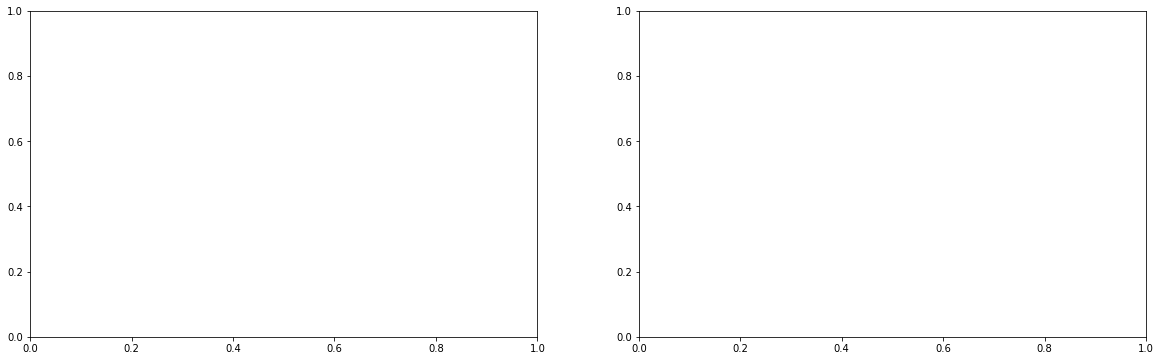

In [ ]:
train_loss=[]
train_loss_box_reg=[]
cis_valid_loss=[]
cis_valid_loss_box_reg=[]
trans_valid_loss=[]
trans_valid_loss_box_reg=[]
fig, ax =plt.subplots(1,2, figsize=(20,6))

for i in range(1):
  train_loss.append(all_train_logs[i].meters['loss'].value)
  train_loss_box_reg.append(all_train_logs[i].meters['loss_box_reg'].value)

  trans_valid_loss.append(all_trans_valid_logs[i].meters['loss'].value)
  trans_valid_loss.append(all_trans_valid_logs[i].meters['loss_box_reg'].value)

  #cis_valid_loss.append(all_cis_valid_logs[i].meters['loss'].value)
  #cis_valid_loss_box_reg.append(all_cis_valid_logs[i].meters['loss_box_reg'].value)

ax[0].plot(np.arange(1),train_loss, label='train')
ax[0].plot(np.arange(1),trans_valid_loss, label='trans valid')
#ax[0].plot(np.arange(num_epochs),cis_valid_loss, label='cis valid')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(np.arange(num_epochs),train_loss_box_reg,label='train')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')

To obtain predicitons

In [ ]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image=list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
  pred=model(image)

Text(0.5, 1.0, 'After NMS')

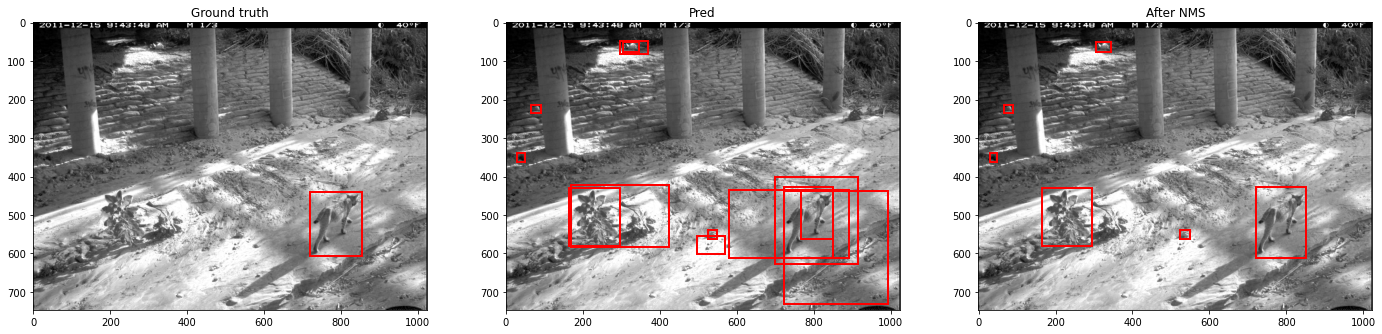

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[0][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

ax[1].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in range(len(pred[0]['boxes'])):
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[1].add_patch(rect)
ax[1].set_title('Pred')

#NMS
iou_threshold=0.005 # param to tune
boxes_to_keep=torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
ax[2].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[2].add_patch(rect)

ax[2].set_title('After NMS')


In [ ]:
# ' For evaluation, we consider a detected box to be correct if its IoU≥ 0.5 with a ground truth box.'


In [ ]:
# doesnt seem to change something to do this before the MAP 
pred[0]['boxes']=pred[0]['boxes'][boxes_to_keep]
pred[0]['labels']=pred[0]['labels'][boxes_to_keep]
pred[0]['scores']=pred[0]['scores'][boxes_to_keep]

Metrics

In [ ]:
metric = MeanAveragePrecision( max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())

{'map': tensor(-1.),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.8000),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_2': tensor(0.8000),
 'mar_2_per_class': tensor(-1.),
 'mar_large': tensor(0.8000),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


In [ ]:
model.roi_heads # original roi heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [ ]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (animal) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.roi_heads # new roi heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

In [ ]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)

In [ ]:
# We would prob need to change the size in 
# Resize(min_size=(800,), max_size=1333, mode='bilinear')


## CEt Ligne est ecrit par Abdiel
## Celle-ci est écrite par Kevin.

# As well as the output size in the fc of the FastRCNN Predictor
#(cls_score): Linear(in_features=1024, out_features=91, bias=True)
#(bbox_pred): Linear(in_features=1024, out_features=364, bias=True)


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
model.

<bound method GeneralizedRCNN.eager_outputs of FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBa